### Profit maximization & Capacity forecasting for a Manufacturing Unit using Linear Optimization with PuLP

This notebook demonstrates a real world example of intermittent flow variety optimization towards maximum profit. <br>

In the company I used to work, we manufactured components for the railways. We had over 10 different varieties product (each of which was in itself a number extensive assemblies) out of which we had to manufacture 3 to 4 items any given month with minimum quantities to satisfy the customers requirements as per the delivery schedules. Beyond the minimum requirements, we always had room to ship more quantities of these products ahead of schedule and delight the customer.<br>
The question that I was always asking myself was, what should we be making more of so that we maximize our profits while also satisfying the customer, all within a given cost bucket.<br>
It used to be extensive excel work with a hit and trial of number of configurations untill i learned to do linear programming using python.
In this notebook, I will model and solve this problem given a number of constraints of manpower, storage and budget. 

Lets look at some data first:

In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pulp import LpMaximize, LpProblem, lpSum, LpVariable, LpStatus

In [2]:
%matplotlib inline

In [3]:
stock = pd.read_csv('stock_info.csv')
product = pd.read_csv('product_info.csv')

In [4]:
stock

,Material name,Max storage cap (Tons),Rate (Lakhs/Ton)
0,MS,80,0.70
1,SS,40,1.90
2,DT,20,3.50
3,CP,40,0.52
4,RX,30,0.93


In [5]:
product['profit(L)'] = product['Sale Price (Lakhs)'] - product['COGS (Lakhs)']
product

,Product Category,Product Qty (unknowns),Min Req Qty,BOM,COGS (Lakhs),Cycle time (Days),Sale Price (Lakhs),profit(L)
0,General,x1,15,0.6*MS+0.625*SS+0.12*DT+0.58*CP+0.22*RX,2.60,0.8,3.3,0.70
1,Sleeper,x2,8,1.45*MS+0*SS+0.18*DT+0.4*CP+0.3*RX,2.55,0.6,3.4,0.85
2,3Tier,x3,12,1.2*MS+0*SS+0.16*DT+0.38*CP+0.4*RX,2.80,0.8,3.8,1.00
3,2Tier,x4,10,1.2*MS+0.8*SS+0.22DT+0.45*CP+0.42*RX,4.20,1.4,5.9,1.70


#### 1. Problem Definition:

We have 5 kinds of materials (stock_info) that go into manufacturing of 4 different products (product_info).<br> 

<b>Stock_info:</b><br>
Max storage capcity defines the storage constraint on these materials. The Existing inventory is also provided along with the rates per ton.<br>
The raw material names are abbreviations of actual materials that were used such as MS and SS are mild steel and stainless steel respectively.

<b>Product_info:</b><br>
General, Sleeper, 3Tier and 2Tier are different types of coach categories available in the Indian Railways.<br>
The dataframe product_info provides the constraints in terms of min quantity required to be delivered, the cycle time of each product and the costs and the sale price. We will be considering the manpower costs seperately. <br>

<b>Additional Info:</b><br>
Total number of working days in a month = 26 days. At any given moment we have two teams/stations working in tandem which can only work on one kind of product at a time. Hence total of 52 team days.<br> 
The Cost of each team is Rs. 5 Lakhs per month.<br>

Our total utilizable budget is caped at 1.5 Cr.

The question is to find the optimized combination of these products to produce so as to maximize the profit per month keeping in mind that there is a certain amount of minimum requirement for each product.

__Disclaimer__: To protect sensitive information, some of the abbreviations are scrambled and the BOM, Cost & Sale Price information has been skewed heavily. So are storage & budgetary constraints.<br> 
The problem is still designed in a way that can demonstrate the concept applied to the actual manufacturing situation.

#### 2. Working set of linear equations:
1. The objective:<br>
To maximize the profit that can be achieved in a month given the constraints

$$Maximize(\sum \limits _{i=1}^{4}Profit_{i}*x_{i} - Cost_{manpower}) $$
<br>
2. Minimum required production per product:<br>

> i.&emsp;  $ x_{1} \geqslant\ 15 $<br>
> ii.&emsp; $ x_{2} \geqslant\ 8 $<br>
> iii.&emsp; $ x_{3} \geqslant\ 12 $<br>
> iv.&emsp; $ x_{4} \geqslant\ 10 $<br>

3. Work days  availability:<br>
Two teams working in tandem for 26 days a month. Each can work on 1 type of product at a time. 
$$ \sum \limits _{1}^{4}CT(days)_{i}*x_{i} \leqslant\ 52 $$
<br>

4. Materials storage constraints:<br>
Working backwards from the _'BOM'_ column in the Dataframe product, we calculate the requirements of raw materials and equate them with their max allowed storage capacity from _'Max storage Cap (Tons)'_
> i.&emsp; $MS_{Req}$:&emsp; $ 0.6*x_{1}+1.45*x_{2}+1.2*x_{3}+1.2*x_{4} \leqslant\ 80 $<br>
> ii.&emsp; $SS_{Req}$:&emsp; $ 0.625*x_{1}+0.8*x_{4} \leqslant\ 40 $<br>
> iii.&emsp; $DT_{Req}$:&emsp; $ 0.12*x_{1}+0.18*x_{2}+0.16*x_{3}+0.22*x_{4} \leqslant\ 20 $<br>
> iv.&emsp; $CP_{Req}$:&emsp; $ 0.58*x_{1}+0.4*x_{2}+0.38*x_{3}+0.45*x_{4} \leqslant\ 40 $<br>
> iv.&emsp; $RX_{Req}$:&emsp; $ 0.22*x_{1}+0.3*x_{2}+0.4*x_{3}+0.42*x_{4} \leqslant\ 30 $<br>

5. Inventory Budget Constraint:<br>
The final constraint is a total inventory cap of Rs. 1.5 Cr or 150 lakhs. We build this in using the material requirement calculations in step 4 and multiplying with the Rate of each material.<br>

$$ MS_{Req}*0.7 + SS_{Req}*1.9 + DT_{Req}*3.5 + CP_{Req}*0.52 + RS_{Req}*0.93 + Cost_{manpower} \leqslant\ 150 $$

<b>Note about solvers for Linear Programing</b> <br>
__PuLP:__<br>
Is a linear programing API for defining problems and invoking external solvers. By default, PuLP's solver is COIN-OR Branch and Cut Solver. Other solvers such as Gurobi can be used with PuLP.<br>
Other good solvers include:<br>
GLPK: is a good open source solver.<br>
Gurobi, CPLEX and EXPRESS are famous proprietary solvers.

To solve our optimization problem, we build a function. We keep 'budget' and number of teams, n_teams, as variables since we will be looking at different combinations of these two to balance capacity between budget and manpower. For now, we ignore the fact that our capacity might be limited due to machinery constraints and assume that we have enough machinery capacity to absorb all demand we can think of.

In [6]:
# Create the model
def optimize(budget, n_teams, summary):
    model = LpProblem(name="maximize-profit", sense=LpMaximize)

    # 1. Initialize the decision variables with the min production requirements
    min_req = [15, 8, 12, 10]
    x = {i: LpVariable(name=f"x{i}", lowBound=min_req[i-1], cat='Integer') for i in range(1, 5)}

    # Setting the constraints:

    # 2. Work days/ time availability
    work_days = n_teams*26
    ct = product['Cycle time (Days)'].to_list()
    model += (ct[0]*x[1] + ct[1]*x[2] + ct[2]*x[3] + ct[3]*x[4] <= work_days, "work_days")

    # 3. Material constraints
    model += (0.6*x[1] + 1.45*x[2] + 1.2*x[3] + 1.2*x[4] <=  80, "MSreq")
    model += (0.625*x[1] + 0.8*x[4] <=  40, "SSreq")
    model += (0.12*x[1] + 0.18*x[2] + 0.16*x[3] + 0.22*x[4] <=  20, "DTreq")
    model += (0.58*x[1] + 0.4*x[2] + 0.38*x[3] + 0.45*x[4] <=  40, "CPreq")
    model += (0.22*x[1] + 0.3*x[2] + 0.4*x[3] + 0.42*x[4] <=  30, "RXreq")

    # 4. Budget Cap
    # Once we multiply all the prices of materials with their requirements as mentioned above
    # and reduce the manpower costs, we get the following eq:
    model += (2.5337*x[1] + 2.132*x[2] + 1.9696*x[3] + 3.7546*x[4] + n_teams*5 <= budget, 'budget')

    # 5. Set the model objective
    prod = product['profit(L)'].to_list()
    model += prod[0]*x[1] + prod[1]*x[2] + prod[2]*x[3] + prod[3]*x[4] - n_teams*5
    
    # 6. Solve the model
    status = model.solve()    
    
    # 7. Report Results
    mc = model.constraints
    results = pd.Series([budget, n_teams, LpStatus[model.status], x[1].value(), x[2].value(), 
                         x[3].value(), x[4].value(), model.objective.value(), "%.2f" % (-mc['budget'].value()), 
                         "%.2f" % (-mc['work_days'].value()), -mc['MSreq'].value(), -mc['SSreq'].value(), 
                         -mc['DTreq'].value(), -mc['CPreq'].value(), -mc['RXreq'].value()], index=summary.columns)
    
    summary = summary.append(results, ignore_index=True)
    
    return summary

Initialize a summary dataframe that collects all the model information

In [7]:
summary = pd.DataFrame(columns=['budget(L)', 'nteams', 'status', 'x1', 'x2', 'x3', 'x4', 
                                'profit(L)', 'budget_rem(L)', 'days_rem', 'ms_rem', 'ss_rem', 
                                'dt_rem', 'cp_rem', 'rx_rem' ])

#'rem' stands for the remaining quota of the constrained resources.

Running the model for budget = 1.5cr and n_teams=2

In [8]:
summary = optimize(150, 2, summary)
summary

,budget(L),nteams,status,x1,x2,x3,x4,profit(L),budget_rem(L),days_rem,ms_rem,ss_rem,dt_rem,cp_rem,rx_rem
0,150,2,Optimal,15.0,8.0,24.0,10.0,48.3,0.12,2.00,18.6,22.625,10.72,14.48,10.5


Upon optimization, the model tells us to maximize x3 keeping x1, x2 and x4 equal to the minimum requirements. This was we will generate a profit of nearly Rs. 48 lakhs from a budget of Rs. 1.5 Cr. A healthy profit margin of 38%. Of course, we are not deducting other operational expenses such as marketing, branding and after sales, which would lower this number.<br>
We see that we still have a remaining budget of 12 thousand and 2 man-days were left unutilized! Our capacity was limited by our budget in this case.

Now lets try to optimize capacity looking at the sweet spots between budget and n_teams ranging from Rs. 1.5 Cr to 3 Cr and 2 to 5 respectively. This will give us a fair idea in the direction we want to expand our capacities.

In [9]:
# Clearing the summary DataFrame
summary.drop(0, inplace=True)

# Define ranges for budget and teams
budget = np.arange(150, 301, 25)
n_teams = np.arange(2, 6)

# Optimize the problem throughout the range
for n in n_teams:
    for b in budget:
        summary = optimize(b, n, summary)

In [10]:
summary.head()

,budget(L),nteams,status,x1,x2,x3,x4,profit(L),budget_rem(L),days_rem,ms_rem,ss_rem,dt_rem,cp_rem,rx_rem
0,150,2,Optimal,15.0,8.0,24.0,10.0,48.3,0.12,2.00,18.6,22.625,10.72,14.48,10.5
1,175,2,Optimal,15.0,26.0,13.0,10.0,52.6,8.41,-0.00,5.7,22.625,9.24,11.46,9.5
2,200,2,Optimal,15.0,26.0,13.0,10.0,52.6,33.41,-0.00,5.7,22.625,9.24,11.46,9.5
3,225,2,Optimal,15.0,26.0,13.0,10.0,52.6,58.41,-0.00,5.7,22.625,9.24,11.46,9.5
4,250,2,Optimal,15.0,26.0,13.0,10.0,52.6,83.41,-0.00,5.7,22.625,9.24,11.46,9.5


Lets generate some statistics for evaluating our performance.

In [11]:
constraints = ['budget_rem(L)', 'days_rem', 'ms_rem', 'ss_rem', 'dt_rem', 'cp_rem', 'rx_rem']
summary['days_rem'] = summary['days_rem'].astype('float')
summary['budget_rem(L)'] = summary['budget_rem(L)'].astype('float')
summary['nteams'] = summary['nteams'].astype('int')

# Total monthly output of the manufacturing unit
summary['throughput'] = summary.apply(lambda row: round((row.x1+row.x2+row.x3+row.x4),0) 
                                        if row.status=='Optimal' else 0,
                                        axis=1)
# Monthly utilization of manpower
summary['team_util'] = summary.apply(lambda row: round(100*(1 - row.days_rem/(row.nteams*26)),2), axis=1)
# Which resource became our bottleneck
summary['critical resource'] = summary[constraints].idxmin(axis=1)
# Level of the bottleneck resource
summary['critical res level'] = round(summary[constraints].min(axis=1),2)

Lets look at the results and find those sweet spots.

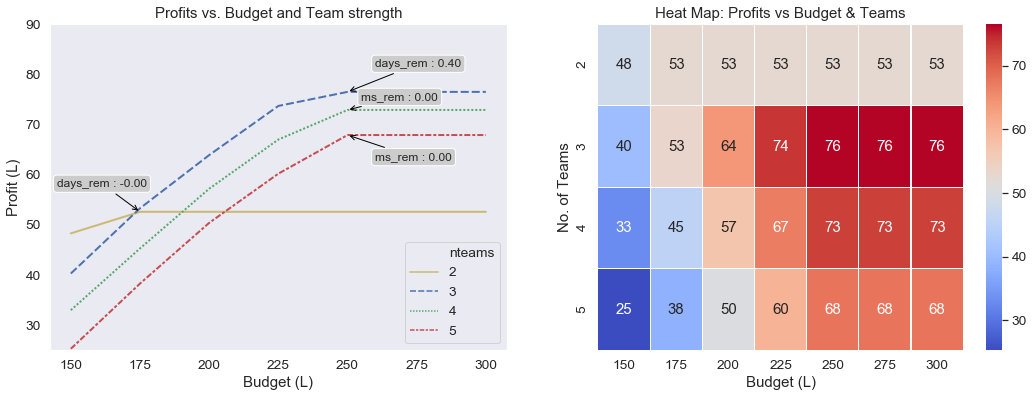

In [13]:
%matplotlib inline
sns.set_style('dark')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

# Plotting the profits over budget and team range
sns.set(font_scale=1.25)
sns.lineplot(x='budget(L)', y='profit(L)', data=summary, hue='nteams', 
             palette=['y', 'b', 'g', 'r'], style='nteams', lw=2, ax=ax1)

# Setting up data and annotations for marking peak points and limitations 
prmax_id = [summary[summary['nteams']==n]['profit(L)'].idxmax() for n in n_teams]
arrowprops = dict(arrowstyle = "->", color='black')
bbox = dict(boxstyle ="round", fc ="0.8")

# Plotting annots
for i, idx in enumerate(prmax_id):
    b = summary.loc[idx, 'profit(L)']
    a = summary.loc[idx, 'budget(L)']
    xytext = [(a-30, b+5), (a+10, b+5), (a+5, b+2), (a+10, b-5)]
    ax1.annotate('%s : %.2f' %(summary.loc[idx, 'critical resource'], summary.loc[idx, 'critical res level']),
                 xy=(a, b), xytext=xytext[i], arrowprops=arrowprops, bbox=bbox, fontsize=12)

ax1.legend(loc=4)
ax1.set(xticks=budget, xlabel='Budget (L)', ylabel='Profit (L)', title='Profits vs. Budget and Team strength',
        ylim=(25, 90))

# Heatmap to show which configuration yields the maximum profits
heat = summary['profit(L)'].to_numpy().reshape(4, 7)
sns.heatmap(heat, linewidth=0.1, cmap='coolwarm', annot=True, xticklabels=budget, yticklabels=n_teams, ax=ax2)
ax2.set(xlabel='Budget (L)', ylabel='No. of Teams', title='Heat Map: Profits vs Budget & Teams')

plt.show()

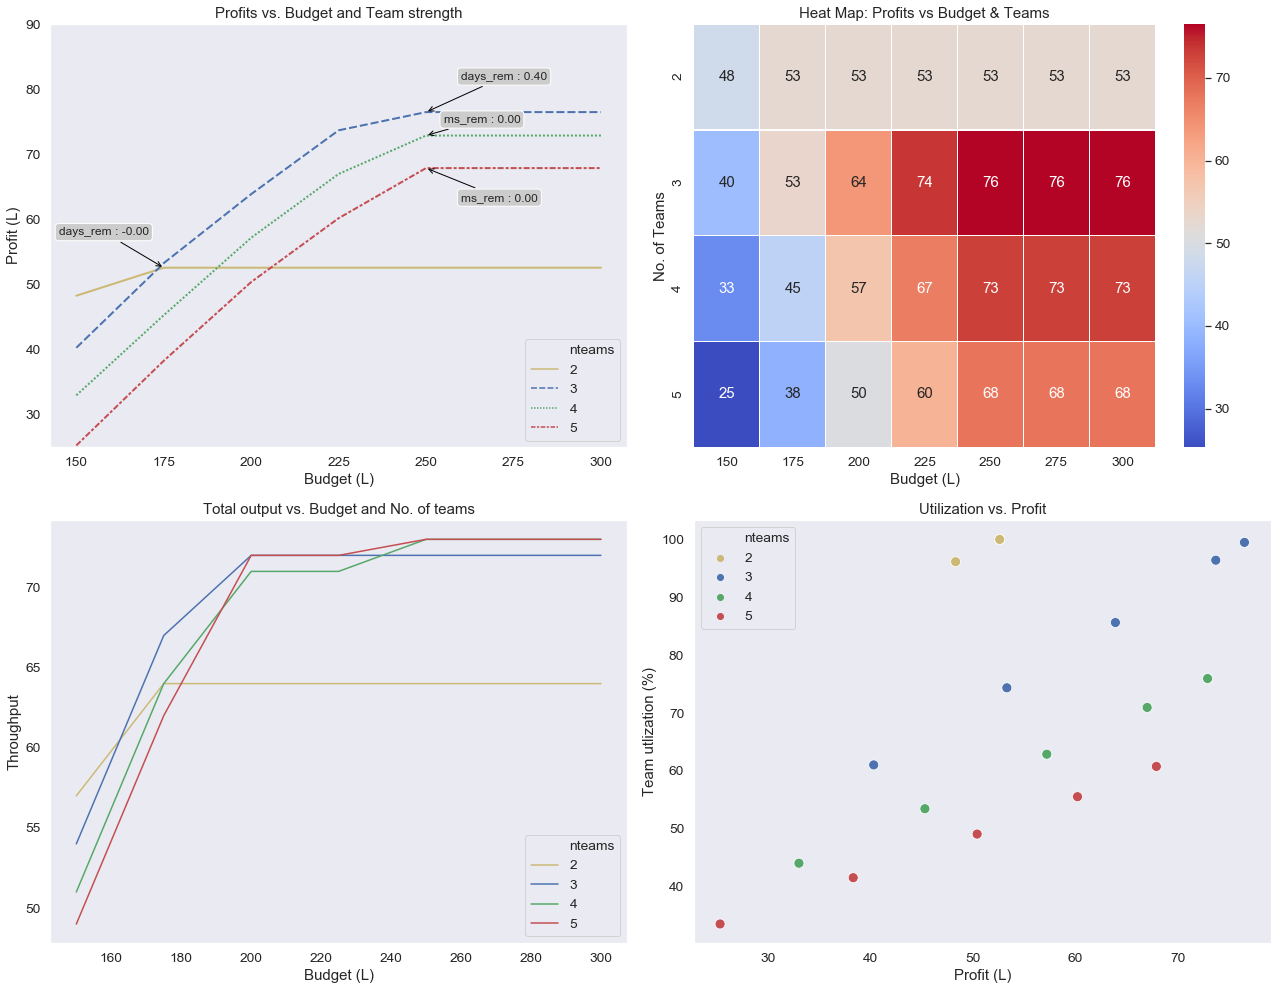

In [24]:
%matplotlib inline
sns.set_style('dark')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,14))

# Plotting the profits over budget and team range
sns.set(font_scale=1.25)
sns.lineplot(x='budget(L)', y='profit(L)', data=summary, hue='nteams', 
             palette=['y', 'b', 'g', 'r'], style='nteams', lw=2, ax=ax1)

# Setting up data and annotations for marking peak points and limitations 
prmax_id = [summary[summary['nteams']==n]['profit(L)'].idxmax() for n in n_teams]
arrowprops = dict(arrowstyle = "->", color='black')
bbox = dict(boxstyle ="round", fc ="0.8")

# Plotting annots
for i, idx in enumerate(prmax_id):
    b = summary.loc[idx, 'profit(L)']
    a = summary.loc[idx, 'budget(L)']
    xytext = [(a-30, b+5), (a+10, b+5), (a+5, b+2), (a+10, b-5)]
    ax1.annotate('%s : %.2f' %(summary.loc[idx, 'critical resource'], summary.loc[idx, 'critical res level']),
                 xy=(a, b), xytext=xytext[i], arrowprops=arrowprops, bbox=bbox, fontsize=12)

ax1.legend(loc=4)
ax1.set(xticks=budget, xlabel='Budget (L)', ylabel='Profit (L)', title='Profits vs. Budget and Team strength',
        ylim=(25, 90))

# Heatmap to show which configuration yields the maximum profits
heat = summary['profit(L)'].to_numpy().reshape(4, 7)
sns.heatmap(heat, linewidth=0.1, cmap='coolwarm', annot=True, xticklabels=budget, yticklabels=n_teams, ax=ax2)
ax2.set(xlabel='Budget (L)', ylabel='No. of Teams', title='Heat Map: Profits vs Budget & Teams')

# Plotting total output vs. Budget vs. No. of teams
sns.lineplot(x='budget(L)', y='throughput', data=summary, hue='nteams', palette=['y', 'b', 'g', 'r'], ax=ax3)
ax3.set(xlabel='Budget (L)', ylabel='Throughput', title='Total output vs. Budget and No. of teams')
ax3.legend(loc=4)

# Plotting utilization vs profits
sns.scatterplot(x='profit(L)', y='team_util', data=summary, hue='nteams', palette=['y', 'b', 'g', 'r'], 
                s=100, ax=ax4)
ax4.set(xlabel='Profit (L)', ylabel='Team utlization (%)', title='Utilization vs. Profit')

plt.tight_layout()
plt.show()

The plot above shows the profits that can be acheived with increasing budget and number of teams.<br>
With 2 teams, our profit maxes out at 53 lakhs/month with a budget of 1.75 Lakhs. We cannot utilize anymore captial since we dont have the manpower to pullout a throughput of more than 64 units. Hence, the work days is our bottleneck in this case.<br>

For 3, 4 & 5 teams, we see that the bottleneck comes out to the material storage capacity of MS. We see profits rising till a budget of Rs. 250 Cr and go flat from there on out. Profits are highest for a configuration of 3 teams and reduce for a configuration of 4 and 5 teams which clearly has to do with utilization.<br>

The best configuration in terms of profits, with a fixed constraint on our storage capacity, is a configuration of 3 teams and 2.5 Cr of capital.<br>